Importing necessary libraries

In [ ]:
!pip install pandas
!pip install xlrd

In [ ]:
import pandas as pd
import random
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

####Loading the data

In [ ]:
df = pd.read_excel('Cust Seg Data.xlsx',
                   dtype = {"INVOICE_DATE": str,
                            "CUST_ACCOUNT":str,
                            "Amount":float})

In [ ]:
print("\n")
print(df[24:29])



           INVOICE_DATE  CUST_ACCOUNT    Amount
24  2019-09-13 00:00:00  12COD0000719   1248.72
25  2019-09-13 00:00:00  12COD0000719    201.67
26  2019-10-26 00:00:00  12COD0000719      0.00
27  2019-10-26 00:00:00  12COD0000719      0.00
28  2019-11-10 00:00:00  12COD0000719  16817.60


####Feature Engineering

In [ ]:
#Extracting necessary data and calculating the feature values
random.seed(3)
CustID = df['CUST_ACCOUNT'].tolist()
UniqueCustID = set(CustID)
UniqueCustID = list(UniqueCustID)
UniqueCustID = random.sample(UniqueCustID,5000)
Rec = []
Recency = []
Frequency = []
Monetary = []

for i in UniqueCustID:
  mydf = df[df['CUST_ACCOUNT'] == i]
  Dates = mydf['INVOICE_DATE'].tolist()
  Frequency.append(len(set(Dates)))
  Rec.append(Dates[len(Dates)-1])
  temp = mydf[mydf['Amount']>0]
  Amount = temp['Amount'].tolist()
  Monetary.append(round(sum(Amount),2))

In [ ]:
#Finding the last date in the data
Rec = [datetime.strptime(ts, "%Y-%m-%d %H:%M:%S").date() for ts in Rec]
Rec.sort()
sorteddates = [datetime.strftime(ts, "%Y-%m-%d") for ts in Rec]
lastDate = sorteddates[len(sorteddates)-1]
lastDate = datetime.strptime(lastDate, "%Y-%m-%d").date()

for i in range(len(Rec)):
  temp = lastDate - Rec[i]
  Recency.append(temp.days)

In [ ]:
scaler = StandardScaler()

myRFM = [[Recency[i],Frequency[i],Monetary[i]] for i in range(len(Frequency))]
scaler.fit(myRFM)
mystdRFM = scaler.transform(myRFM)

####EDA

In [ ]:
recStd = mystdRFM[:,0]
freqStd = mystdRFM[:,1]
monStd = mystdRFM[:,2]

(array([473., 658., 505., 514., 834., 295., 318., 349., 551., 503.]),
 array([  0. ,  35.5,  71. , 106.5, 142. , 177.5, 213. , 248.5, 284. ,
        319.5, 355. ]),
 <a list of 1 Patch objects>)

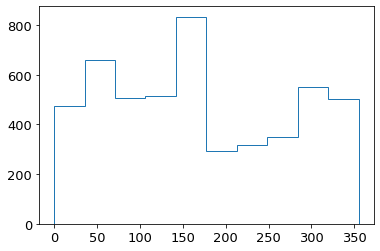

In [ ]:
plt.hist(Recency,histtype='step')

####Calculating RFM Scores

In [ ]:
def getScore(X,Ctg):
  #print("\n",X)
  score = 0
  if X<Ctg[0]:
    score = 1
  else:
    for i in range(len(Ctg)-1):
      if ((X>=Ctg[i]) and (X<Ctg[i+1])):
        score = i+2
  #print("Score:",score)
  return score

#Calculating quantiles of Recency, Frequency and Monetary Value
q = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
FreqLim = np.quantile(a = Frequency, q = q)
MonLim = np.quantile(a = Monetary, q = q)
#dates = [datetime.strptime(ts, "%Y-%m-%d %H:%M:%S").date() for ts in Rec]
#RecLim = np.quantile(a = dates, q = q)
RecLim = np.quantile(a=Recency,q=q)
#Calculating RFM Score based on the quantiles
r = []
f = []
m = []

for i in range(len(Frequency)):
  f.append(getScore(Frequency[i],FreqLim))
  m.append(getScore(Monetary[i],MonLim))
  #r.append(getScore(dates[i],RecLim))
  r.append(getScore(Recency[i],RecLim))

####Clustering

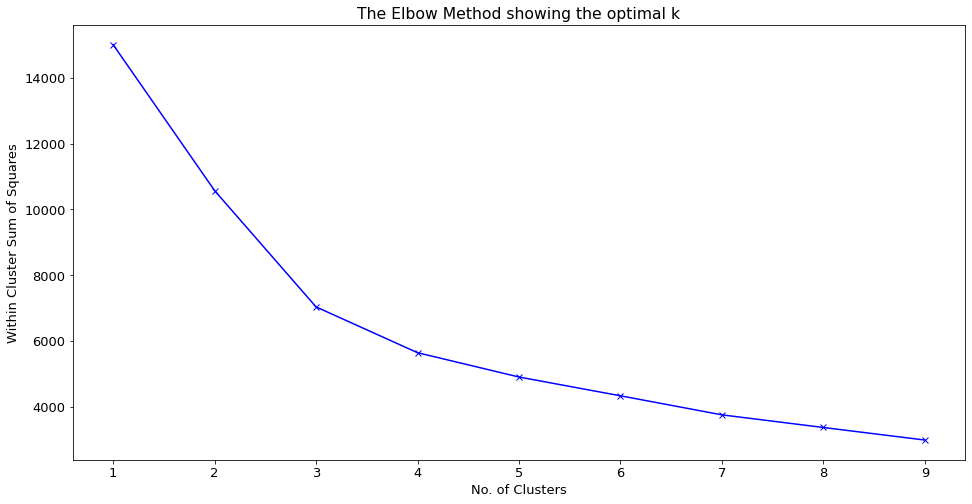

In [ ]:
mystdRFM = np.array(mystdRFM)
WSS = []
#Elbow Method
for i in range(1,10):
  kmeans = KMeans(n_clusters=i, random_state=0).fit(mystdRFM)
  WSS.append(kmeans.inertia_)

plt.figure(figsize=(16,8))
plt.plot(range(1,10), WSS, 'bx-')
plt.xlabel('No. of Clusters')
plt.ylabel('Within Cluster Sum of Squares')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [ ]:
kmeans = KMeans(n_clusters=4, random_state=0).fit(mystdRFM)
Labels = kmeans.labels_
Centers = kmeans.cluster_centers_

In [ ]:
#For 4 Clusters
colorMap = []
for i in Labels:
  if i==3:
    colorMap.append("#F6BE00")    #dark yellow
  elif i==1:
    colorMap.append("green")
  elif i==2:
    colorMap.append("red")
  else:
    colorMap.append("#006c84")  #Azure Green Blue from Arctic Sunrise by Neil Richards

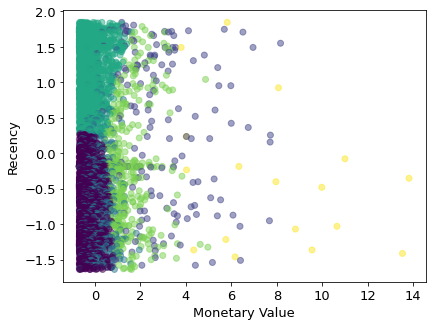

In [ ]:
plt.figure(figsize=(6.5,5))
plt.scatter(mystdRFM[:,2],mystdRFM[:,0],c=colorMap,alpha=0.5)
plt.rcParams.update({'font.size': 13})
plt.xlabel("Monetary Value",fontsize=13)
plt.ylabel("Recency",fontsize=13)
#plt.savefig("Image.png",dpi=600)
plt.show()

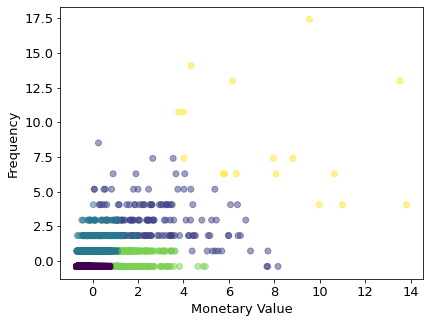

In [ ]:
plt.figure(figsize=(6.5,5))
plt.scatter(mystdRFM[:,2],mystdRFM[:,1],c=colorMap,alpha=0.5)
plt.rcParams.update({'font.size': 13})
plt.xlabel("Monetary Value",fontsize=13)
plt.ylabel("Frequency",fontsize=13)
#plt.savefig("Image.png",dpi=600)
plt.show()

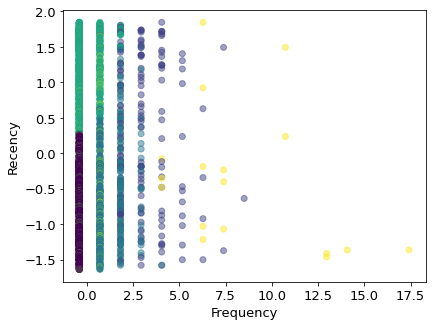

In [ ]:
plt.figure(figsize=(6.5,5))
plt.scatter(mystdRFM[:,1],mystdRFM[:,0],c=colorMap,alpha=0.5)
plt.rcParams.update({'font.size': 13})
plt.xlabel("Frequency",fontsize=13)
plt.ylabel("Recency",fontsize=13)
#plt.savefig("Image.png",dpi=600)
plt.show()

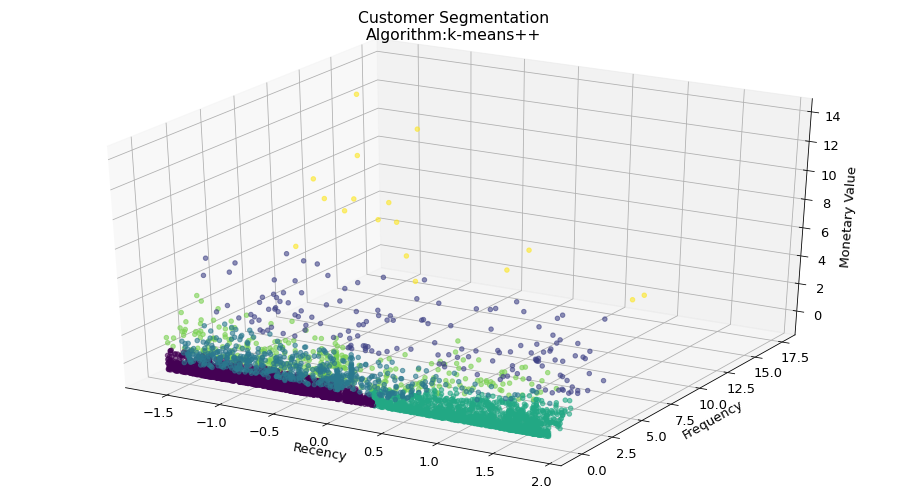

In [ ]:
# Creating figure
fig = plt.figure(figsize = (16, 9))
ax = plt.axes(projection ="3d")

# Add x, y gridlines
ax.grid(b = True, color ='grey')

# Creating plot
ax.scatter3D(mystdRFM[:,0], mystdRFM[:,1], mystdRFM[:,2], alpha=0.6,c = colorMap)

algorithm = 'k-means++'
plt.title("Customer Segmentation\nAlgorithm:%s" %(algorithm))
ax.set_xlabel('Recency')#, fontweight ='bold')
ax.set_ylabel('Frequency')#, fontweight ='bold')
ax.set_zlabel('Monetary Value')#, fontweight ='bold')

#show plot
plt.show()

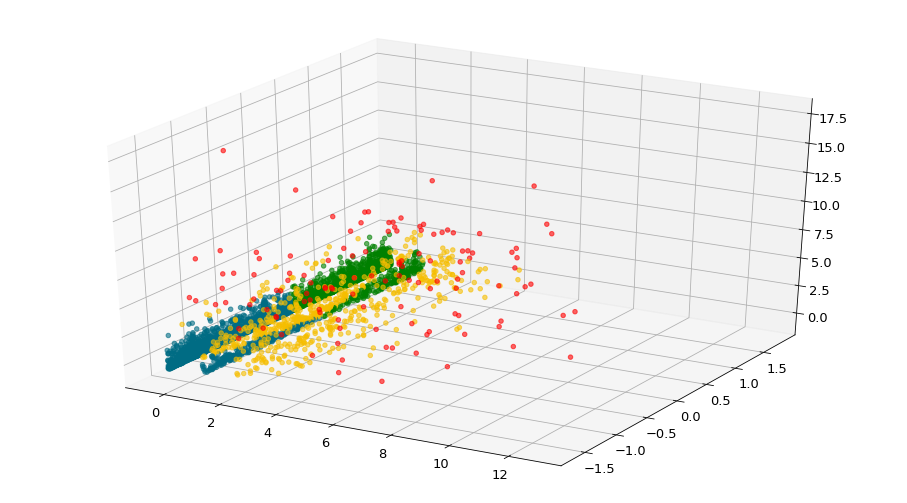

In [ ]:
# Creating figure
fig = plt.figure(figsize = (16, 9))
ax = plt.axes(projection ="3d")

# Add x, y gridlines
ax.grid(b = True, color ='grey')

# Creating plot
ax.scatter3D(mystdRFM[:,1], mystdRFM[:,0], mystdRFM[:,2], alpha=0.6,c = colorMap)

'''algorithm = 'k-means++'
plt.title("Event:%s\nAlgorithm:%s" %(event,algorithm))
ax.set_xlabel('X-axis', fontweight ='bold')
ax.set_ylabel('Y-axis', fontweight ='bold')
ax.set_zlabel('Z-axis', fontweight ='bold')'''

# show plot
plt.show()

####Illustrations for the Toy Dataset

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt


In [ ]:
n_samples = 100
random.seed(10)
X = np.concatenate((
    np.random.normal((-3, 1),1, size=(n_samples, 2)),
    np.random.normal((2, 4),1, size=(n_samples, 2)),
    np.random.normal((4, -1),1, size=(n_samples, 2)),
))
y = np.concatenate((([0]*100),([1]*100),([2]*100)))

In [ ]:
colorMap = ['red','green','blue']
proto = random.sample(range(300),3)
centers = [X[t] for t in proto]
centers = np.array(centers)

In [ ]:
centers

array([[ 3.3056147 , -1.99580469],
       [-2.34640395,  2.62017425],
       [ 3.80923144,  0.08093802]])

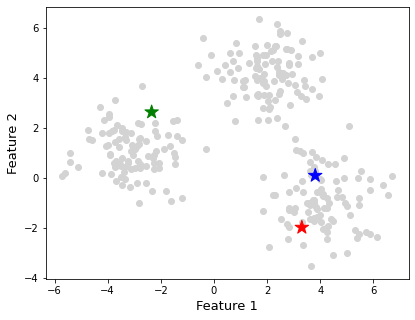

In [ ]:
plt.figure(figsize=(6.5,5))
plt.scatter(X[:,0],X[:,1],c='lightgrey')
plt.scatter(centers[:,0],centers[:,1],s=200,c=["red","green","blue"],marker='*')

plt.rcParams.update({'font.size': 13})
plt.xlabel("Feature 1",fontsize=13)
plt.ylabel("Feature 2",fontsize=13)
#plt.savefig("Image.png",dpi=600)
plt.show()

In [ ]:
colorMapsL = []
labels=[]
for i in range(len(X)):
  dist = []
  for k in range(len(centers)):
    dist.append((np.linalg.norm(X[i]-centers[k]))**2)
  lab = dist.index(np.min(dist))
  labels.append(lab)
  colorMapsL.append(colorMap[lab])


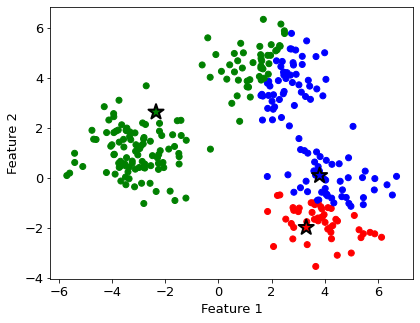

In [ ]:
plt.figure(figsize=(6.5,5))
plt.scatter(X[:,0],X[:,1],c=colorMapsL)
plt.scatter(centers[:,0],centers[:,1],s=250,c=["red","green","blue"],marker='*',edgecolors='black',linewidths=2)

plt.rcParams.update({'font.size': 13})
plt.xlabel("Feature 1",fontsize=13)
plt.ylabel("Feature 2",fontsize=13)
#plt.savefig("Image.png",dpi=600)
plt.show()

In [ ]:
for j in range(len(centers)):
  indices = [i for i in range(len(labels)) if labels[i] ==j]
  clust = np.array([X[t] for t in indices])
  centers[j] = np.mean(clust, axis=0)

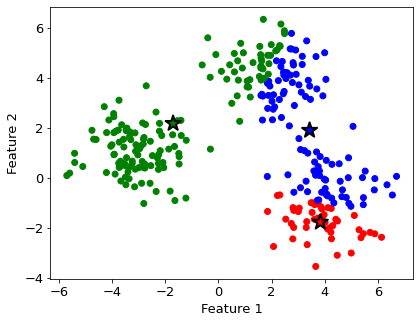

In [ ]:
plt.figure(figsize=(6.5,5))
plt.scatter(X[:,0],X[:,1],c=colorMapsL)
plt.scatter(centers[:,0],centers[:,1],s=250,c=["red","green","blue"],marker='*',edgecolors='black',linewidths=2)

plt.rcParams.update({'font.size': 13})
plt.xlabel("Feature 1",fontsize=13)
plt.ylabel("Feature 2",fontsize=13)
#plt.savefig("Image.png",dpi=600)
plt.show()

In [ ]:
colorMapsL = []
labels=[]
for i in range(len(X)):
  dist = []
  for k in range(len(centers)):
    dist.append((np.linalg.norm(X[i]-centers[k]))**2)
  lab = dist.index(np.min(dist))
  labels.append(lab)
  colorMapsL.append(colorMap[lab])

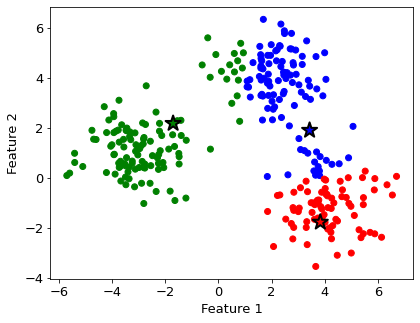

In [ ]:
plt.figure(figsize=(6.5,5))
plt.scatter(X[:,0],X[:,1],c=colorMapsL)
plt.scatter(centers[:,0],centers[:,1],s=250,c=["red","green","blue"],marker='*',edgecolors='black',linewidths=2)

plt.rcParams.update({'font.size': 13})
plt.xlabel("Feature 1",fontsize=13)
plt.ylabel("Feature 2",fontsize=13)
#plt.savefig("Image.png",dpi=600)
plt.show()

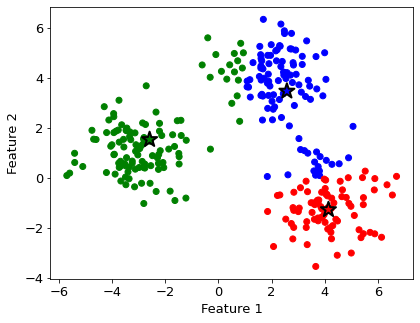

In [ ]:
for j in range(len(centers)):
  indices = [i for i in range(len(labels)) if labels[i] ==j]
  clust = np.array([X[t] for t in indices])
  centers[j] = np.mean(clust, axis=0)

plt.figure(figsize=(6.5,5))
plt.scatter(X[:,0],X[:,1],c=colorMapsL)
plt.scatter(centers[:,0],centers[:,1],s=250,c=["red","green","blue"],marker='*',edgecolors='black',linewidths=2)

plt.rcParams.update({'font.size': 13})
plt.xlabel("Feature 1",fontsize=13)
plt.ylabel("Feature 2",fontsize=13)
#plt.savefig("Image.png",dpi=600)
plt.show()

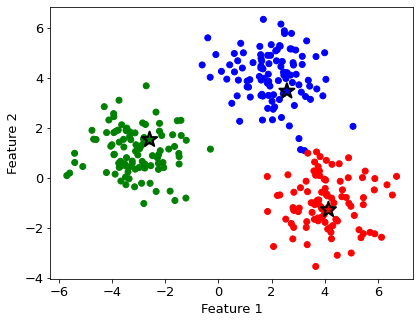

In [ ]:
colorMapsL = []
labels=[]
for i in range(len(X)):
  dist = []
  for k in range(len(centers)):
    dist.append((np.linalg.norm(X[i]-centers[k]))**2)
  lab = dist.index(np.min(dist))
  labels.append(lab)
  colorMapsL.append(colorMap[lab])

plt.figure(figsize=(6.5,5))
plt.scatter(X[:,0],X[:,1],c=colorMapsL)
plt.scatter(centers[:,0],centers[:,1],s=250,c=["red","green","blue"],marker='*',edgecolors='black',linewidths=2)

plt.rcParams.update({'font.size': 13})
plt.xlabel("Feature 1",fontsize=13)
plt.ylabel("Feature 2",fontsize=13)
#plt.savefig("Image.png",dpi=600)
plt.show()

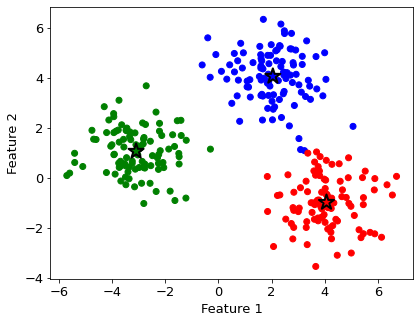

In [ ]:
for j in range(len(centers)):
  indices = [i for i in range(len(labels)) if labels[i] ==j]
  clust = np.array([X[t] for t in indices])
  centers[j] = np.mean(clust, axis=0)

plt.figure(figsize=(6.5,5))
plt.scatter(X[:,0],X[:,1],c=colorMapsL)
plt.scatter(centers[:,0],centers[:,1],s=250,c=["red","green","blue"],marker='*',edgecolors='black',linewidths=2)

plt.rcParams.update({'font.size': 13})
plt.xlabel("Feature 1",fontsize=13)
plt.ylabel("Feature 2",fontsize=13)
#plt.savefig("Image.png",dpi=600)
plt.show()

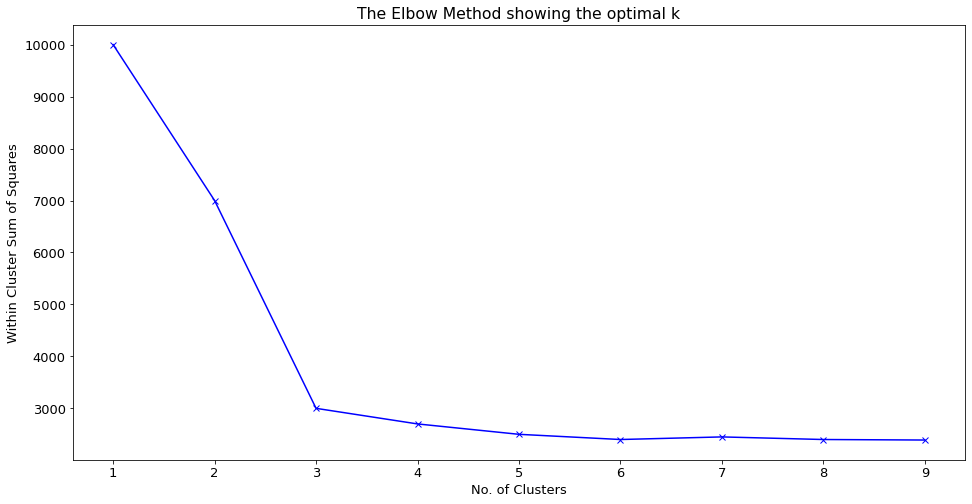

In [ ]:
WSS = [10000,7000,3000,2700,2500,2400,2450,2400,2390]

plt.figure(figsize=(16,8))
plt.plot(range(1,10), WSS, 'bx-')
plt.xlabel('No. of Clusters')
plt.ylabel('Within Cluster Sum of Squares')
plt.title('The Elbow Method showing the optimal k')
plt.show()